## Processing pipeline
Start with a zip file and:
 - Unzip it
 - For each file inside it
   - ODV Parse it
   - Filter it or what not
   - append to parsed list
   - Combine with metadata pulled from other places
   - Create columns specifically for DwC
 - Merge parsed list into single DF
 - write to DwC
   - Take column matching dictionaries
   - Rename columns to match DwC standards
   - Write to CSV

In [1]:
! pip install --upgrade --force-reinstall pyodv

  Using cached pyodv-0.0.4-py3-none-any.whl (6.7 kB)
  Attempting uninstall: pyodv
    Found existing installation: pyodv 0.0.4
    Uninstalling pyodv-0.0.4:
      Successfully uninstalled pyodv-0.0.4


In [2]:
# Std
import zipfile
import pathlib
import os
import re

# NonStd
import dask.dataframe as ddf
import numpy as np
import pandas as pd
import geopy.distance
import itertools
import requests
import json

# Custom
import pyodv

import logging
log = logging.getLogger('main') 

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
pyodv.__version__

'0.0.4'

### Vars and paths


In [4]:
def odv_to_dwc(odv_zip):
    '''
    The actual function that does the conversions from 
    the ODV zip into the DwC
    '''
    log.info(f'===Converting {odv_zip} to DwC...===')
    folder_dict = create_folder_structure(odv_zip)
    unzip(folder_dict)
    parsed_df = parse_odv(folder_dict)

    # Create new columns
    applied_df = parsed_df.apply(lambda row: create_wkt(row), axis='columns', result_type='expand')
    applied_df = applied_df.rename(columns={0: 'CoordinateUncertaintyInMeters', 1: 'footprint_wkt'})
    parsed_df  = pd.concat([parsed_df, applied_df], axis='columns')
    
    df_id = parsed_df.apply(lambda row: create_IDs(row), axis='columns', result_type='expand')
    df_id = df_id.rename(columns={0: 'eventID', 1: 'occurrenceID'})
    parsed_df  = pd.concat([parsed_df, df_id], axis='columns')
    
    parsed_df['occurrenceStatus'] = parsed_df.apply(lambda row: find_occurrenceStatus(row), axis='columns', result_type='expand')
    parsed_df['basisOfRecord'] = parsed_df.apply(lambda row: find_basisOfRecord(row), axis='columns', result_type='expand')

    # Create EventCore File
    dwc_event = odv_dwc_mapping(parsed_df, event_mapping) 
    dwc_event.to_csv(folder_dict.get('event_path'))

    # Create OccCore File
    dwc_occ = odv_dwc_mapping(parsed_df, occ_mapping)
    dwc_occ.to_csv(folder_dict.get('occ_path'))

    # Create EMOF File
    # params = convert_params_to_df()
    # dwc_occ = <some function>
    # dwc_emof.to_csv(folder_dict.get('emof_path'))

    # Create Metadata File
    # params = convert_params_to_df()
    # dwc_occ = <some function>
    # dwc_emof.to_json(folder_dict.get('meta_path'))

    # Dump all data
    parsed_df.to_csv(folder_dict.get('all_data_path'))

    log.debug(f'===Finished converting {odv_zip} to DwC===')

    return parsed_df

def create_folder_structure(odv_zip):
    '''
    Create a directory structure next to the odv_zip file:
    > <some-file>.zip
    > /meta.zip
        
    > ./<some-file>/unzip
    > ./<some-file>/unzip/odv1.csv, odv2.csv ...

    > ./<some-file>/dwc
    > ./<some-file>/dwc/occ.csv
    > ./<some-file>/dwc/event.csv
    > ./<some-file>/dwc/emof.csv
    '''
    log.debug(f'Creating folder structure for {odv_zip}...')
    zipped_path = pathlib.Path(odv_zip).parent 
    meta_zipped_path = zipped_path.joinpath('meta.zip')

    unzip_folder = pathlib.Path(zipped_path).joinpath('unzip')
    unzip_folder.mkdir(parents=True, exist_ok=True)

    meta_file = pathlib.Path(odv_zip).stem + '.csv'
    meta_path = unzip_folder.joinpath(meta_file)
    
    dwc_folder = pathlib.Path(zipped_path).joinpath('dwc')
    dwc_folder.mkdir(parents=True, exist_ok=True)
    
    event_file = pathlib.Path(zipped_path).joinpath('dwc').joinpath('event.csv')
    occ_file = pathlib.Path(zipped_path).joinpath('dwc').joinpath('occ.csv')
    emof_file = pathlib.Path(zipped_path).joinpath('dwc').joinpath('emof.csv')
    all_file = pathlib.Path(zipped_path).joinpath('dwc').joinpath('all.csv')

    folder_dict = {'odv_zip': odv_zip,
                   'meta_zip': meta_zipped_path,
                   'unzip_folder': unzip_folder,
                   'dwc_path': dwc_folder,
                   'meta_path': meta_path,
                   'occ_path': occ_file,
                   'emof_path': emof_file,
                   'event_path': event_file,
                   'all_data_path': all_file}

    return folder_dict

def unzip(folder_dict):
    '''
    Unzips the ODV file into the unzip folder
    '''
    log.debug(f"Unzipping file {folder_dict.get('odv_zip')} into {folder_dict.get('unzip_folder')}...")
    with zipfile.ZipFile(folder_dict.get('odv_zip'), 'r') as zip_ref:
        zip_ref.extractall(folder_dict.get('unzip_folder'))
    
    log.debug(f"Unzipping Metadata file {folder_dict.get('meta_zip')} into {folder_dict.get('unzip_folder')}...")
    with zipfile.ZipFile(folder_dict.get('meta_zip'), 'r') as zip_ref:
        zip_ref.extractall(folder_dict.get('unzip_folder'))

    return 

def parse_odv(folder_dict):
    '''
    Parse all the ODV files in the unzipped path into 
    a single data object.
    '''
    unzipped_path = folder_dict.get('unzip_folder')
    meta_path = folder_dict.get('meta_path')

    log.debug(f'Parsing files in {unzipped_path}...')
    config = {'occurrenceStatus_hardcode': 'present'}

    odv_list  = []
    df_list = [] 
    ref_list = []
    for filename in os.listdir(unzipped_path):
        
        f = os.path.join(unzipped_path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try:
                log.debug(f'===== {f} =====')
                parsed_file = pyodv.ODV_Struct(f) 
                odv_list.append(parsed_file) 
                ref_list.append(parsed_file.refs[0])
                this_df = pd.concat([parsed_file.df_data, parsed_file.df_var],axis=1)
                this_df['scope'] = parsed_file.refs[0]['@sdn:scope']
                this_df['defined_by'] = parsed_file.refs[0]['@xlink:href']
    #             this_df['occurrenceStatus'] = config.get('occurrenceStatus_hardcode', 'present')
                df_list.append(this_df)
            except Exception as err:
                log.debug(err)

    metadata_path =  meta_path
    try:
        log.debug(f'Reading metadata file: {metadata_path}...')
        metadata_df = pd.read_csv(metadata_path)
        metadata_df['LOCAL_CDI_ID_split'] = metadata_df['LOCAL_CDI_ID'].str.split(pat="/").str[0]
    except:
        log.warning('Problem with reading metadata file!')
        metadata_df = pd.DataFrame()

    merged_df = pd.concat(df_list, axis=0) 
    merged_df = merged_df.join(metadata_df.set_index('LOCAL_CDI_ID_split'), on='LOCAL_CDI_ID', how='left', rsuffix = '_meta')
    merged_df.reset_index(level=None, drop=True, inplace = True)
    return merged_df

def create_IDs(row):
    '''
    Create EventID and OccuranceID. 
    Both are a concatenation of the other columns. They also become the columns to join on in the Occurance Table
    and Event table. 
    '''
    if 'yyyy-mm-ddThh:mm:ss.sss' in row.index:
        eventID = str(row['LOCAL_CDI_ID']) + '_' + str(row['Station']) + '_' + str(row['yyyy-mm-ddThh:mm:ss.sss'])
    elif 'YYYY-MM-DDThh:mm:ss.sss' in row.index:
        eventID = str(row['LOCAL_CDI_ID']) + '_' + str(row['Station']) + '_' + str(row['YYYY-MM-DDThh:mm:ss.sss'])
    
    try:  
        if pd.isnull(row['ScientificNameID [#]']):
            aphia_id = row['ScientificName [none]'].replace(' ','_')
        else:
            aphia_id = re.findall(r"\d{1,}$", row['ScientificNameID [#]'])[0]
    except Exception as err:
        print(print(row))
        print(err)
    if np.isnan(row['SubsampleID [#]']):
        occurrenceID = str(row['SampleID [#]']) + '_' + str(aphia_id)
    else:
        occurrenceID = str(row['SampleID [#]']) + '_' + str(row['SubsampleID [#]']) + '_' + str(aphia_id)
    
    return eventID, occurrenceID
    
def create_wkt(row):
    '''
    Create WKT from the dataset for each row
    Uses Latitude 1,Latitude 2,Longitude 1,Longitude 2 
    from metadata. Must return uncertainty in meters. 
    '''
#     max_lat = merged_df['Latitude [degrees_north]'].max()
#     min_lat = merged_df['Latitude [degrees_north]'].min()
#     max_lon = merged_df['Longitude [degrees_east]'].max()
#     min_lon = merged_df['Longitude [degrees_east]'].min()
    try:
        max_lat = max(row['Latitude 1'], row['Latitude 2'])
        min_lat = min(row['Latitude 1'], row['Latitude 2'])
        max_lon = max(row['Longitude 1'], row['Longitude 2'])
        min_lon = min(row['Longitude 1'], row['Longitude 2'])
        bounding_wkt = f"POLYGON (({min_lon} {min_lat}, {min_lon} {max_lat}, {max_lon} {max_lat}, {max_lon} {min_lat}, {min_lon} {min_lat}))"
        
        lat_c = (max_lat + min_lat)/2
        lon_c = (max_lon + min_lon)/2
        
        coord_uncertainty = geopy.distance.geodesic((min_lon, min_lat), (lon_c, lat_c)).m 
          
    except Exception as err:
        print(err)
        bounding_wkt = None
        coord_uncertainty = None
        
    return coord_uncertainty, bounding_wkt


def find_occurrenceStatus(row):
    '''
    Do some kind of occurenceStatus thing.
    '''
    return 'present'


def find_basisOfRecord(row):
    '''
    Do something to create BasisOfRecord. Was 
    '''
    return 'material sample'

def get_units_from_nerc(row):
    '''
    Get the english units from the nerc vocab
    server. 
    ''' 
    nerc_uri = row['measurementUnitID']
    xx = requests.get(nerc_uri + '?_profile=nvs&_mediatype=application/ld+json')
    alt_labels = json.loads(xx.content)['altLabel']
    if isinstance(alt_labels, list):
        for x in alt_labels:
            if isinstance(x, str):
                alt_label = x
    elif isinstance(alt_labels, str):
        alt_label = alt_labels
    else:
        alt_label = 'Unknown'
        log.warning(f'Failure to handle Label: {alt_labels}')
    return alt_label

def convert_params_to_df(odv_list):    
    '''
    Convert the ODV Params into Nerc URI's in order to get them 
    closer towards EMOF. 
    '''
    combined = list(itertools.chain.from_iterable([x.params for x in odv_list]))
    params_df = pd.DataFrame(combined).drop_duplicates()
     
    params_df['measurementType'] = params_df['subject'].apply(lambda x: x.split(':')[-1]) 
    params_df['measurementUnitID'] = params_df['units'].apply(lambda x: f"https://vocab.nerc.ac.uk/collection/P06/current/{x.split('::')[-1]}/")
    params_df['measurementTypeID'] = params_df['object'].apply(lambda x: f"https://vocab.nerc.ac.uk/collection/P01/current/{x.split('::')[-1]}/")
    params_df['measurementUnit'] = params_df.apply(lambda x: get_units_from_nerc(x), axis=1)
    
    return params_df


def odv_dwc_mapping(df, map_dict):
    dwc_col_list = []
    for dwc_colname, odv_colname in map_dict.items():
#         log.warning(f'Checking {dwc_colname}:{odv_colname}')
        if odv_colname is not None:
            this_column = ''
            try: 
                this_column = [i for i in df.columns if i.startswith(odv_colname)] 
#                 log.warning(f'Changing {this_column} column to {dwc_colname}')
                dwc_col = df[this_column]
                dwc_col.name = dwc_colname
                dwc_col_list.append(dwc_col)
            except Exception as err:
                log.warning(f'Tried Changing {this_column} column to {dwc_colname}')
                log.error(err)
    mapped_df = pd.concat(dwc_col_list, axis=1)
    return mapped_df

In [5]:
event_mapping = {
        'eventID':'eventID',
        'eventDate':'yyyy-mm-ddThh:mm:ss.sss',
        'decimalLatitude':'Latitude [degrees_north]',
        'decimalLongitude':'Longitude [degrees_east]',
        'institutionCode':'EDMO_code',
        'datasetName':'Data Set name',
        'maximumDepthInMeters':'MaximumObservationDepth [m]',
        'minimumDepthInMeters':'MinimumObservationDepth [m]',
        'coordinateUncertaintyInMeters':None,
        'footprintWKT':'footprint_wkt', # How to put in a single value into table? Shouldn't this be metadata?
        'type':None,
        'parenEventID':None,
        'dataGeneralizations':None,
        'eventRemarks':None,
        'samplingProtocol':'Samplingprotocol [#]',
        'locationID':'Station',
        'locality':None,
        'locationRemarks':None,
        }

occ_mapping = {
            'eventID': 'eventID',
            'occurrenceID': 'occurrenceID',
            'basisOfRecord': 'basisOfRecord',
            'occurrenceStatus': 'occurrenceStatus', # Hardcoded? 
            'scientificName': 'ScientificName',
            'scientificNameID': 'ScientificNameID',
#             'identificationQualifier': '',
#             'scientificNameAuthorship': '',
#             'identificationRemarks': '',
#             'catalogNumber': '',
#             'collectionCode': '',
#             'occurrenceRemarks': '',
#             'recordedBy': '',
#             'associatedSequences': '',
#             'associatedMedia': '',
#             'identifiedBy': '',
#             'kingdom': '',
#             'phylum': '',
#             'class': '',
#             'order': '',
#             'family': '',
#             'genus': '',
#             'subgenus': '',
#             'specificEpithet': '',
#             'infraspecificEpithet': '',
#             'taxonRank': '',
            }   

In [6]:
input_zip = './datasets/'
output_folder = './output/'


In [7]:
for folder in os.listdir(input_zip):
    for subfolder in os.listdir(input_zip + folder):
        if subfolder.startswith('order'):
            print(subfolder)
            df = odv_to_dwc(input_zip + folder +'/' + subfolder)


order_61214_unrestricted.zip
order_61215_unrestricted.zip
EDMO_code                                                                    486.0
Station                                                     60002661_BIO_Posidonie
YYYY-MM-DDThh:mm:ss.sss                                    2007-04-18T00:00:00.000
LOCAL_CDI_ID                                                60002661_BIO_Posidonie
Type                                                                             *
                                                       ...                        
CDI-record id                                                              3093858
LOCAL_CDI_ID_meta                                        60002661_BIO_Posidonie/v2
CDI-partner                      Ifremer, Scientific Information Systems for th...
CoordinateUncertaintyInMeters                                             0.211897
footprint_wkt                    POLYGON ((43.1263656616 5.7508168221, 43.12636...
Name: 0, Length: 79, dtype: o

KeyError: 'SubsampleID [#]'

In [ ]:

this_column = [i for i in df.columns if i.startswith('ScientificNameID')][0]
this_column

In [ ]:
pd.set_option('display.max_columns', None)
df 

In [ ]:
0/0

In [ ]:
odv_zip = input_zip

zipped_path = pathlib.Path(odv_zip) 
file_name = zipped_path.stem
unzip_folder = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('unzip')
dwc_folder = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('dwc')
meta_file = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('meta.json')
event_file = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('dwc').joinpath('event.csv')
occ_file = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('dwc').joinpath('occ.csv')
emof_file = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('dwc').joinpath('emof.csv')
all_file = pathlib.Path(zipped_path.parent).joinpath(file_name).joinpath('dwc').joinpath('all.csv')

folder_dict = {'odv_zip': odv_zip,
               'unzip_path': unzip_folder,
               'dwc_path': dwc_folder,
               'meta_path': meta_file,
               'occ_path': occ_file,
               'emof_path': emof_file,
               'event_path': event_file
               'all_data_path': all_file}
folder_dict

### Unzip
Input:
  - Zipped file path
  - Location to unzip to

Output
  - Unzipped files in folder

In [ ]:
zipped_path = pathlib.Path(input_zip)
file_name = zipped_path.stem
unzipped_path = pathlib.Path(temp_folder).joinpath(file_name)
with zipfile.ZipFile(input_zip, 'r') as zip_ref:
    zip_ref.extractall(unzipped_path)

### Parse and Merge files
Input:
  - Unzipped dir
Output:
  - Parsed and merged dataframe object.

In [ ]:
config = {'occurrenceStatus_hardcode': 'present'}

odv_list  = []
df_list = [] 
ref_list = []
for filename in os.listdir(unzipped_path):
    f = os.path.join(unzipped_path, filename)
    # checking if it is a file
    if os.path.isfile(f):
        try:
            print(f'===== {f} =====')
            parsed_file = pyodv.ODV_Struct(f) 
            odv_list.append(parsed_file) 
            ref_list.append(parsed_file.refs[0])
            this_df = pd.concat([parsed_file.df_data, parsed_file.df_var],axis=1)
            this_df['scope'] = parsed_file.refs[0]['@sdn:scope']
            this_df['defined_by'] = parsed_file.refs[0]['@xlink:href']
#             this_df['occurrenceStatus'] = config.get('occurrenceStatus_hardcode', 'present')
            df_list.append(this_df)
        except Exception as err:
            print(err)
            print('==============================================================')    

In [ ]:
metadata_path = os.path.join(unzipped_path, 'data.csv')
metadata_df = pd.read_csv(metadata_path)
metadata_df['LOCAL_CDI_ID_split'] = metadata_df['LOCAL_CDI_ID'].str.split(pat="/").str[0]
merged_df = pd.concat(df_list, axis=0) 
merged_df = merged_df.join(metadata_df.set_index('LOCAL_CDI_ID_split'), on='LOCAL_CDI_ID', how='left', rsuffix = '_meta')
merged_df.reset_index(level=None, drop=True, inplace = True)

In [ ]:
# pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
merged_df.iloc[1]

### Write to DwC
When writing to DwC archive there are a couple of xml files created, a folder with the data in it and then it's all zipped.

Taking a look here: https://ipt.gbif.org/manual/en/ipt/2.5/dwca-guide#publishing-dwc-a-manually

Steps required are:
  - Prepare data files
  - Create a Metafile
  - Create a metadata file (eml.xml)
  - Ensure the data files, the metafile (meta.xml) and metadata file (eml.xml) are in the same directory or folder. Compress the folder using one of the support compression formats. The result is a DwC-A.


## Functions to alter data in prep for DwC mapping

In [ ]:
def isParentID(row):
    '''
    This checks for subsampleID's and then shifts them up one heirarchical level. 
    Example: If a dataset row has a SampleID and a SubsampleID then the SampleID should be a ParentEventID and the 
    SubSampleID should be a SampleID. 
    Weird... From
    https://confluence.vliz.be/download/attachments/38700150/seadatanet%20DwC%20mapping.xlsx?version=1&modificationDate=1556881093000&api=v2
    
    TODO: This really needs a good checking
    '''
    if np.isnan(row['SubsampleID [#]']) or str(row['SubsampleID [#]']).lower == 'nan':
        row['IsParent'] = False
        row['ParentEventID'] = np.NaN
    else:
        row['IsParent'] = True
        row['ParentEventID'] = '?'
        row['SampleID [#]'] = '?'
        

In [ ]:
def create_IDs(row):
    '''
    Create EventID and OccuranceID. 
    Both are a concatenation of the other columns. They also become the columns to join on in the Occurance Table
    and Event table. 
    '''
    
    if 'yyyy-mm-ddThh:mm:ss.sss' in row.index:
        eventID = str(row['LOCAL_CDI_ID']) + '_' + str(row['Station']) + '_' + str(row['yyyy-mm-ddThh:mm:ss.sss'])
    elif 'YYYY-MM-DDThh:mm:ss.sss' in row.index:
        eventID = str(row['LOCAL_CDI_ID']) + '_' + str(row['Station']) + '_' + str(row['YYYY-MM-DDThh:mm:ss.sss'])
    
    try:  
        if pd.isnull(row['ScientificNameID [#]']):
            aphia_id = row['ScientificName [none]'].replace(' ','_')
        else:
            aphia_id = re.findall(r"\d{1,}$", row['ScientificNameID [#]'])[0]
    except Exception as err:
        print(print(row))
        print(err)
    if np.isnan(row['SubsampleID [#]']):
        occurrenceID = str(row['SampleID [#]']) + '_' + str(aphia_id)
    else:
        occurrenceID = str(row['SampleID [#]']) + '_' + str(row['SubsampleID [#]']) + '_' + str(aphia_id)
    
    return eventID, occurrenceID
    
    
    

In [ ]:
applied_df = merged_df.apply(lambda row: create_IDs(row), axis='columns', result_type='expand')
applied_df = applied_df.rename(columns={0: 'eventID', 1: 'occurrenceID'})
merged_df  = pd.concat([merged_df, applied_df], axis='columns')

In [ ]:
def create_wkt(row):
    '''
    Create WKT from the dataset for each row
    Uses Latitude 1,Latitude 2,Longitude 1,Longitude 2 
    from metadata. Must return uncertainty in meters. 
    '''
#     max_lat = merged_df['Latitude [degrees_north]'].max()
#     min_lat = merged_df['Latitude [degrees_north]'].min()
#     max_lon = merged_df['Longitude [degrees_east]'].max()
#     min_lon = merged_df['Longitude [degrees_east]'].min()
    try:
        max_lat = max(row['Latitude 1'], row['Latitude 2'])
        min_lat = min(row['Latitude 1'], row['Latitude 2'])
        max_lon = max(row['Longitude 1'], row['Longitude 2'])
        min_lon = min(row['Longitude 1'], row['Longitude 2'])
        bounding_wkt = f"POLYGON (({min_lon} {min_lat}, {min_lon} {max_lat}, {max_lon} {max_lat}, {max_lon} {min_lat}, {min_lon} {min_lat}))"
        
        lat_c = (max_lat + min_lat)/2
        lon_c = (max_lon + min_lon)/2
        
        coord_uncertainty = geopy.distance.geodesic((min_lon, min_lat), (lon_c, lat_c)).m 
          
    except Exception as err:
        print(err)
        bounding_wkt = None
        coord_uncertainty = None
        
    return coord_uncertainty, bounding_wkt


def find_occurrenceStatus(row):
    '''
    Do some kind of occurenceStatus thing.
    '''
    return 'present'


def find_basisOfRecord(row):
    '''
    Do something to create BasisOfRecord. Was 
    '''
    return 'material sample'


In [ ]:
'Type' in df.iloc[1].index

In [ ]:
applied_df = merged_df.apply(lambda row: create_wkt(row), axis='columns', result_type='expand')
applied_df = applied_df.rename(columns={0: 'CoordinateUncertaintyInmeters', 1: 'footprint_wkt'})
merged_df  = pd.concat([merged_df, applied_df], axis='columns')
merged_df['occurrenceStatus'] = merged_df.apply(lambda row: find_occurrenceStatus(row), axis='columns', result_type='expand')
merged_df['basisOfRecord'] = merged_df.apply(lambda row: find_basisOfRecord(row), axis='columns', result_type='expand')

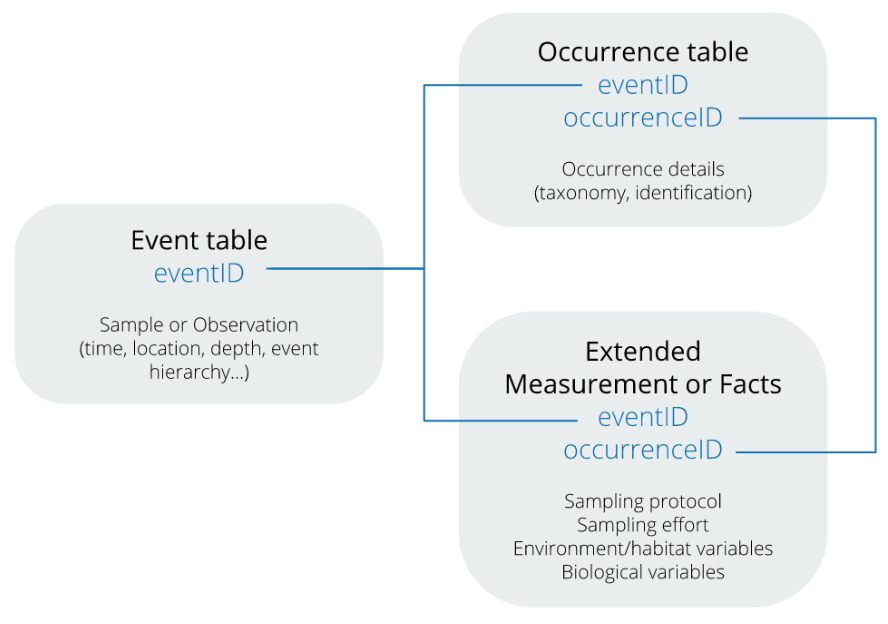

## DwC Terms:
https://dwc.tdwg.org/terms/#dcterms:references

In [ ]:
event_mapping = {
        'eventID':'eventID',
        'eventDate':'yyyy-mm-ddThh:mm:ss.sss',
        'decimalLatitude':'Latitude [degrees_north]',
        'decimalLongitude':'Longitude [degrees_east]',
        'institutionCode':'EDMO_code',
        'datasetName':'Data Set name',
        'maximumDepthInMeters':'MaximumObservationDepth [m]',
        'minimumDepthInMeters':'MinimumObservationDepth [m]',
        'coordinateUncertaintyInMeters':None,
        'footprintWKT':'footprint_wkt', # How to put in a single value into table? Shouldn't this be metadata?
        'type':None,
        'parenEventID':None,
        'dataGeneralizations':None,
        'eventRemarks':None,
        'samplingProtocol':'Samplingprotocol [#]',
        'locationID':'Station',
        'locality':None,
        'locationRemarks':None,
        }


In [ ]:
occ_mapping = {
            'eventID': 'eventID',
            'occurrenceID': 'occurrenceID',
            'basisOfRecord': 'basisOfRecord',
            'occurrenceStatus': 'occurrenceStatus', # Hardcoded? 
            'scientificName': 'ScientificName [none]',
            'scientificNameID': 'ScientificNameID [#]',
#             'identificationQualifier': '',
#             'scientificNameAuthorship': '',
#             'identificationRemarks': '',
#             'catalogNumber': '',
#             'collectionCode': '',
#             'occurrenceRemarks': '',
#             'recordedBy': '',
#             'associatedSequences': '',
#             'associatedMedia': '',
#             'identifiedBy': '',
#             'kingdom': '',
#             'phylum': '',
#             'class': '',
#             'order': '',
#             'family': '',
#             'genus': '',
#             'subgenus': '',
#             'specificEpithet': '',
#             'infraspecificEpithet': '',
#             'taxonRank': '',
}

How to add to eMoF
  - 1) measurementtype = column header withouth the part between brackets
  - 2) measurementUnit = the part between brackets from the collumn header
  - 3) measurementtypeID = P01 from the semanticHeader
  - 4) measurementUnitID = P06 from the semanticHeader


In [ ]:
def get_units_from_nerc(row):
    '''
    Get the english units from the nerc vocab
    server. 
    ''' 
    nerc_uri = row['measurementUnitID']
    xx = requests.get(nerc_uri + '?_profile=nvs&_mediatype=application/ld+json')
    alt_labels = json.loads(xx.content)['altLabel']
    if isinstance(alt_labels, list):
        for x in alt_labels:
            if isinstance(x, str):
                alt_label = x
    elif isinstance(alt_labels, str):
        alt_label = alt_labels
    else:
        alt_label = 'Unknown'
        print('what do')
    return alt_label

def convert_params_to_df(odv_list):    
    '''
    Convert the ODV Params into Nerc URI's in order to get them 
    closer towards EMOF. 
    '''
    combined = list(itertools.chain.from_iterable([x.params for x in odv_list]))
    params_df = pd.DataFrame(combined).drop_duplicates()
     
    params_df['measurementType'] = params_df['subject'].apply(lambda x: x.split(':')[-1]) 
    params_df['measurementUnitID'] = params_df['units'].apply(lambda x: f"https://vocab.nerc.ac.uk/collection/P06/current/{x.split('::')[-1]}/")
    params_df['measurementTypeID'] = params_df['object'].apply(lambda x: f"https://vocab.nerc.ac.uk/collection/P01/current/{x.split('::')[-1]}/")
    params_df['measurementUnit'] = params_df.apply(lambda x: get_units_from_nerc(x), axis=1)
    
    return params_df

param_df = convert_params_to_df(odv_list)
param_df

In [ ]:
merged_df.iloc[1]

In [ ]:
[
 'measurementID',       # Just a number?
 'eventID',             # Already sorted
 'occurrenceID',        # Already sorted
#  'measurementType',     # column header without the part between brackets
#  'measurementTypeID',   # P01 from the semanticHeader 
 'measurementValue',    # Cell value 
 'measurementValueID',  # ???
#  'measurementUnit',     # the part between brackets from the column header
#  'measurementUnitID',   # P06 from the semanticHeader
#  'measurementAccuracy', # The quality value? 
#  'measurementRemarks'   # ???
]

In [ ]:
# EMOF mapping is pivoting the data into a different form
# Can't do direct mapping? Or can you? 

emof_columns = ['Instrument / gear type',
                'Cruise name',
                'SamplingEffort [m^2]',
                '',
                '',
                '',
                '',
                '']

emof_mapping = {'eventID': '',
                'occurrenceID': '',
                'measurementtype': '',
                'measurementUnit': '',
                'measurementtypeID': '',
                'measurementUnitID': ''}

In [ ]:
dwc_occ

In [ ]:
dwc_event.drop_duplicates() 

In [ ]:
# ! pip install pymsteams

In [ ]:
# webhook_url = 'https://vliz.webhook.office.com/webhookb2/c239f565-b5b6-44cb-a3d2-1910259c0053@923c2a71-7137-497c-b171-8663dbcaf9ed/IncomingWebhook/741bcd50b4f840c8a920434e44bfb6f8/1dc340e1-0404-42e5-9dfc-9313296a13ae'


In [ ]:
# import pymsteams
# myTeamsMessage = pymsteams.connectorcard(webhook_url)
# myTeamsMessage.title("Some Title")
# myTeamsMessage.text("Test Other Message")
# myTeamsMessage.addLinkButton("This is the button Text", "https://github.com/rveachkc/pymsteams/")
# myTeamsMessage.color("#0037ff")


In [ ]:
# # create the section
# myMessageSection = pymsteams.cardsection()

# # Section Title
# myMessageSection.title("Section title")

# # Activity Elements
# myMessageSection.activityTitle("my activity title")
# myMessageSection.activitySubtitle("my activity subtitle")
# myMessageSection.activityImage("http://i.imgur.com/c4jt321l.png")
# myMessageSection.activityText("This is my activity Text")

# # Facts are key value pairs displayed in a list.
# myMessageSection.addFact("this", "is fine")
# myMessageSection.addFact("this is", "also fine")

# # Section Text
# myMessageSection.text("This is my section text")

# # Section Images
# myMessageSection.addImage("http://i.imgur.com/c4jt321l.png", ititle="This Is Fine")

# # Add your section to the connector card object before sending
# myTeamsMessage.addSection(myMessageSection)

# myTeamsMessage.send()